Analyze training results

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Install packages and clone repo
!pip install lightning
!git clone https://github.com/mhbakalar/phla-prediction.git

# Restart runtime after package installation
import os
os.kill(os.getpid(), 9)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_root = '/content/phla-prediction/'

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
cd phla-prediction

In [3]:
import sys
sys.path.append('../')

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

import torch
import models.modules.split_transformer
import models.modules.numeric_transformer
import models.datasets.phla_data
import models.datasets.phla_numeric

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import glob

Load data and model from checkpoint

In [4]:
# Configure data
hits_file = 'data/tstab_data.txt'
aa_order_file = 'data/amino_acid_ordering.txt'
allele_sequence_file = 'data/alleles_95_variable.txt'

predictions = []
for k_fold in range(0,5):
    data = models.datasets.phla_numeric.DataModule(
        hits_file=hits_file,
        aa_order_file=aa_order_file,
        allele_sequence_file=allele_sequence_file,
        train_test_split=0.2,
        batch_size=8,
        predict_mode=False,
        normalize=True,
        num_splits=5,
        k=k_fold
    )
    data.prepare_data()

    # Configure the model
    ckpt_path = "/content/drive/MyDrive/logs/content/phla-prediction/logs/lightning_logs/heads_8_layers_3/version_0/epoch=13-step=59920.ckpt"
    version = "heads_8_layers_3/numeric"
    model = models.modules.split_transformer.SplitTransformer.load_from_checkpoint(ckpt_path)

    # Build the transfer learning model
    transfer_model = models.modules.numeric_transformer.NumericTransformer(learning_rate=1e-4)
    transfer_model.load_base_transformer(model, freeze=True)

    logger = TensorBoardLogger(save_dir='./logs')
    checkpoint_callback = ModelCheckpoint(dirpath=logger.log_dir, save_top_k=1, monitor="val_loss")
    trainer = L.Trainer(
        max_epochs=20,
        log_every_n_steps=1,
        accelerator="gpu",
        callbacks=checkpoint_callback
    )
    trainer.fit(transfer_model, datamodule=data)

    # Reload the best model
    best_model = models.modules.numeric_transformer.NumericTransformer.load_from_checkpoint(checkpoint_callback.best_model_path)
    p = trainer.predict(best_model, datamodule=data)
    predictions.append(p)

Lightning automatically upgraded your loaded checkpoint from v1.9.3 to v2.0.0rc0. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint --file ../logs/lightning_logs/heads_8_layers_3/version_0/epoch=13-step=59920.ckpt`
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [75]:
predictions = trainer.predict(transfer_model, datamodule=data)

/Users/mbakalar/Documents/Hacohen/Computational/lightning/lightning/src/lightning/pytorch/trainer/connectors/data_connector.py:208: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 90/90 [00:07<00:00, 12.60it/s]


Epoch 7:  16%|█▌        | 7/44 [17:40<1:33:23, 151.44s/it, v_num=29]


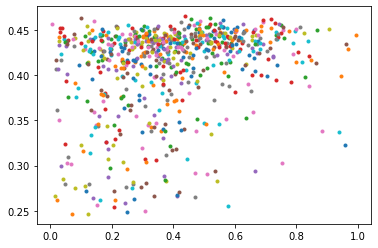

In [76]:
for p in predictions:
    plt.plot(p[1], p[2], '.')

In [ ]:
inputs, labels, outputs = zip(*[batch for batch in predictions])

inputs = torch.vstack(list(inputs))
labels = torch.vstack(list(labels))
outputs = torch.vstack(list(outputs))

In [ ]:
data.peptide_dataset.inverse_aa_map[22] = ''
peptides = [data.peptide_dataset.decode_peptide(pep) for pep in inputs[:,-12:]]
df = pd.DataFrame({'seq':peptides, 'labels':labels.squeeze(), 'outputs':outputs.squeeze()})
df.to_csv("/content/drive/MyDrive/logs/content/phla-prediction/logs/lightning_logs/heads_8_layers_3/version_0/output.csv",index=False)

In [66]:
def core_seq(seq):
  return seq[0:5] + seq[-4:-1]

df['core_seq'] = df['seq'].map(core_seq)

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 46 but got size 1 for tensor number 1 in the list.

In [5]:
# Configure data
hits_file = '../data/tstab_data.txt'
aa_order_file = '../data/amino_acid_ordering.txt'
allele_sequence_file = '../data/alleles_95_variable.txt'

data = models.datasets.phla_numeric.DataModule(
    hits_file=hits_file,
    aa_order_file=aa_order_file,
    allele_sequence_file=allele_sequence_file,
    train_test_split=0.2,
    batch_size=64,
    predict_mode=False
)
data.prepare_data()

# Load the original model checkpoint to get hyperparameters
ckpt_path = "../logs/lightning_logs/heads_8_layers_3/version_0/epoch=13-step=59920.ckpt"
model = models.modules.split_transformer.SplitTransformer.load_from_checkpoint(ckpt_path)

# Load the model and patch to recover attention outputs
numeric_ckpt_file = sorted(glob.glob("../logs/lightning_logs/heads_8_layers_3/numeric/*.ckpt"))[-1]
transfer_model = models.modules.numeric_transformer.NumericTransformer()
transfer_model.load_base_transformer(model)

'''
attn_outputs = {}
for i, key in enumerate(model.transformers):
    item = model.transformers[key]
    attn_outputs[key] = attention.patch_attention(item.modules())
'''

# Run predictions
trainer = L.Trainer()
predictions = trainer.predict(transfer_model, datamodule=data)

Lightning automatically upgraded your loaded checkpoint from v1.9.3 to v2.0.0rc0. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint --file ../logs/lightning_logs/heads_8_layers_3/version_0/epoch=13-step=59920.ckpt`
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/mbakalar/Documents/Hacohen/Computational/lightning/lightning/src/lightning/pytorch/trainer/connectors/data_connector.py:208: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0:   0%|          | 0/12 [00:00<?, ?it/s]Predict!
torch.Size([64, 1024])
torch.Size([64, 1])
Predicting DataLoader 0:   8%|▊         | 1/12 [00:00<00:06,  1.59it/s]Predict!
torch.Size([64, 1024])
torch.Size([64, 1])
Predicting DataLoader 0:  17%|█▋        | 2/12 [00:01<00:06,  1.63it/s]Predict!
torch.Size([64, 1024])
torch.Size([64, 1])
Predicting DataLoader 0:  25%|██▌       | 3/12 [00:02<00:06,  1.30it/s]Predict!
torch.Size([64, 1024])
torch.Size([64, 1])
Predicting DataLoader 0:  33%|███▎      | 4/12 [00:02<00:05,  1.37it/s]Predict!
torch.Size([64, 1024])
torch.Size([64, 1])
Predicting DataLoader 0:  42%|████▏     | 5/12 [00:03<00:04,  1.45it/s]Predict!
torch.Size([64, 1024])
torch.Size([64, 1])
Predicting DataLoader 0:  50%|█████     | 6/12 [00:04<00:04,  1.38it/s]Predict!
torch.Size([64, 1024])
torch.Size([64, 1])
Predicting DataLoader 0:  58%|█████▊    | 7/12 [00:04<00:03,  1.40it/s]Predict!
torch.Size([64, 1024])
torch.Size([64, 1])
Predicting DataLoader 0:

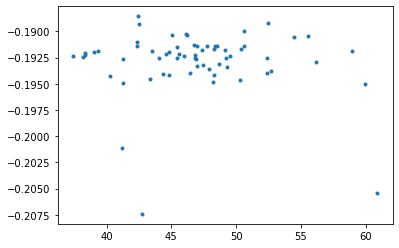

In [9]:
plt.plot(predictions[0][1], predictions[0][2], '.')

In [21]:
checkpoint = torch.load(ckpt_file)

In [27]:
checkpoint['hparams_name']

KeyError: 'hparams_name'

In [22]:
checkpoint['state_dict'].keys()

odict_keys(['transformer.pep_embedding.weight', 'transformer.hla_embedding.weight', 'transformer.pep_transformer_encoder.encoder_layer.self_attn.in_proj_weight', 'transformer.pep_transformer_encoder.encoder_layer.self_attn.in_proj_bias', 'transformer.pep_transformer_encoder.encoder_layer.self_attn.out_proj.weight', 'transformer.pep_transformer_encoder.encoder_layer.self_attn.out_proj.bias', 'transformer.pep_transformer_encoder.encoder_layer.linear1.weight', 'transformer.pep_transformer_encoder.encoder_layer.linear1.bias', 'transformer.pep_transformer_encoder.encoder_layer.linear2.weight', 'transformer.pep_transformer_encoder.encoder_layer.linear2.bias', 'transformer.pep_transformer_encoder.encoder_layer.norm1.weight', 'transformer.pep_transformer_encoder.encoder_layer.norm1.bias', 'transformer.pep_transformer_encoder.encoder_layer.norm2.weight', 'transformer.pep_transformer_encoder.encoder_layer.norm2.bias', 'transformer.pep_transformer_encoder.transformer_encoder.layers.0.self_attn.in

In [269]:
batch = 0
[data.peptide_dataset.decode_peptide(pep)[-12:] for pep in predictions[batch][0]]

['ALYNDISHMKI.',
 'SPLDMKDGFLA.',
 'AEGIHTGQFVY.',
 'KILPVGGIKEK.',
 'MEITEELRQYF.',
 'ALLGAGCDPEL.',
 'HSNEQTLQRSW.',
 'VYAPPVGGFSF.',
 'QEALNLFKSIW.',
 'LQERNPENWAY.',
 'HSFYPTPALQW.',
 'TANSKLVIITA.',
 'KYMPNVKVAVF.',
 'ALLENMEGLFL.',
 'MELSAVGERVF.',
 'PYQATIDGVRF.',
 'SSLPALLFKAR.',
 'AGFQRDLGSLR.',
 'SLLPPTALVGL.',
 'AYLPVNESFGF.',
 'LLYDLADQLHA.',
 'KLWDVREGMCR.',
 'LLPEEIKSSFL.',
 'IPYAQPPLGRL.',
 'KILGPQGNTIK.',
 'EEVPTQESVKW.',
 'RLIDDEVRILI.',
 'TLFHDPWKLLI.',
 'YTEQLLRGLSY.',
 'FPFKPPQRIEA.',
 'ILLDHEKEWKL.',
 'IPYSPDVQIHA.',
 'TTFTWNINHAR.',
 'TYLPREILNLI.',
 'GMLDPLEVHLL.',
 'IGAQVLGKILW.',
 'ATELDAWLAKY.',
 'YPNIELSYEVV.',
 'ATDIQVLALTY.',
 'SGSSDGTIRLW.',
 'EELTIDHVPIW.',
 'IYQEIILANHF.',
 'NEFIDASRLVY.',
 'SLWESSQELLK.',
 'HVIDSIVGDGI.',
 'SMAPGLVIQAV.',
 'IYLAPGDYHCF.',
 'RNKDPILHVLR.',
 'KSFGWPSFITY.',
 'RIKEIAQDALK.',
 'RLMEFNSLINK.',
 'VEMYDPTRNEW.',
 'KVIDGERVIGR.',
 'MVQPINLIFRY.',
 'ALPKELPLISS.',
 'VSAPLSTIINW.',
 'RAFTCDDLFRF.',
 'SSELATEVHFY.',
 'AEQQITEVFVL.

In [285]:
len(data.peptide_dataset.aa_map.keys())

22

In [ ]:
attn_outputs['pep_transformer_encoder'][1].outputs[batch]

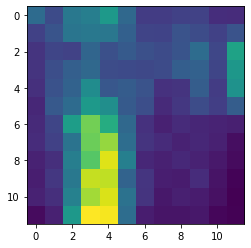

In [273]:
batch = 0
attn_map = attn_outputs['pep_transformer_encoder'][1].outputs[batch]
plt.imshow(attn_map.mean(axis=0)[2,:,:])

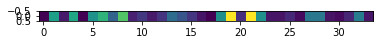

In [265]:
batch = 0
attn_map = attn_outputs['hla_transformer_encoder'][0].outputs[batch]
plt.imshow(attn_map.mean(axis=0)[:,:,:].mean(axis=0).sum(axis=0).unsqueeze(0))

In [194]:
batch = 0
attn_map = attn_outputs['hla_transformer_encoder'][1].outputs[batch]
plt.imshow(attn_map.mean(axis=0)[0,:,:])

IndexError: list index out of range

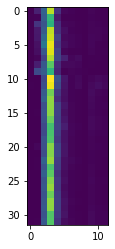

In [243]:
batch = 5
attn_map = attn_outputs['phla_transformer_encoder'][1].outputs[batch]
attn_batch_mean = attn_map.mean(axis=0)
plt.imshow(attn_batch_mean[14,:32,:12])

Analyze model attention

In [246]:
attn_maps = attn_outputs['phla_transformer_encoder'][1].outputs
data_avg = torch.vstack(list(attn_maps)).mean(axis=0)

/var/folders/zx/cktqv751087bh3h282sl63nr0000gp/T/ipykernel_12776/2791628265.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(5, 5))


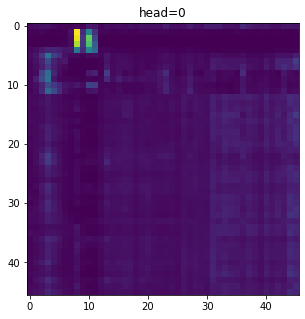

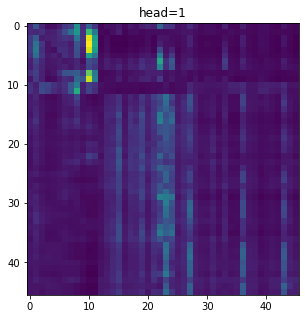

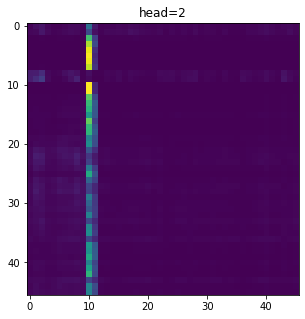

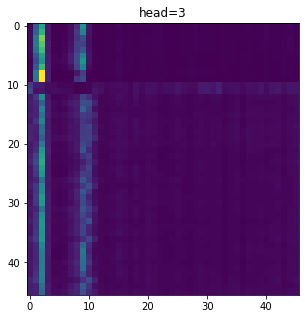

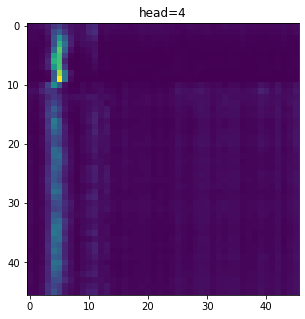

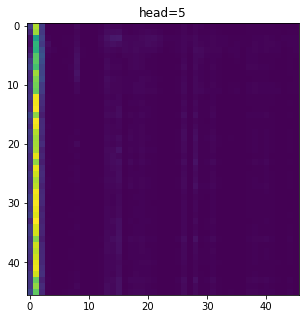

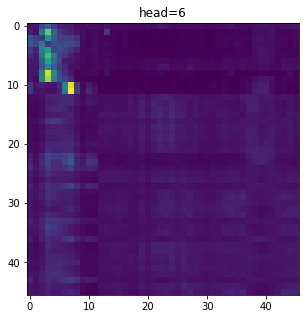

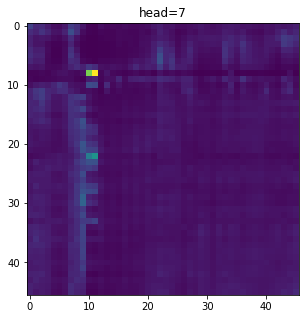

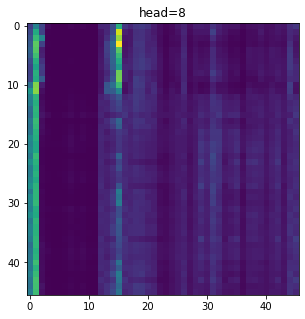

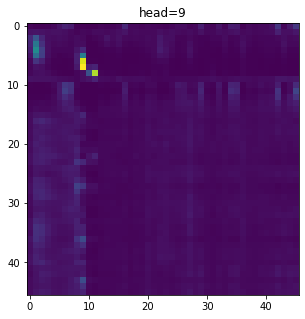

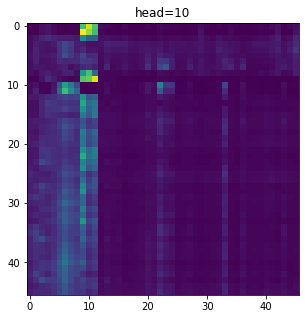

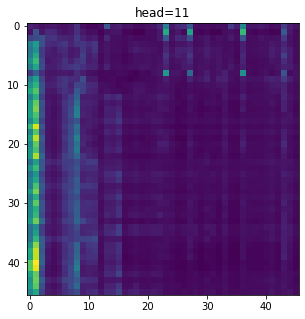

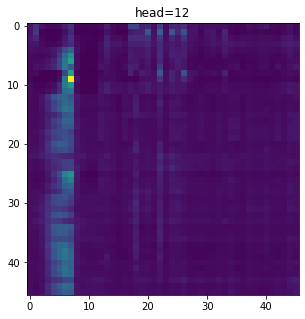

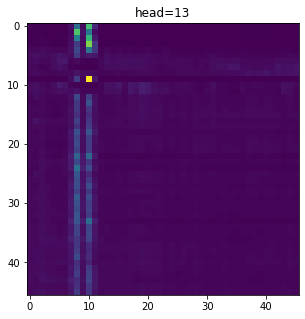

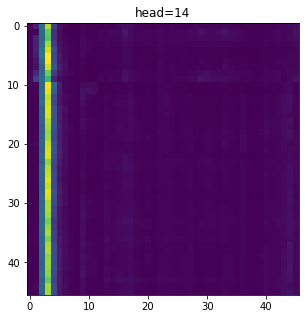

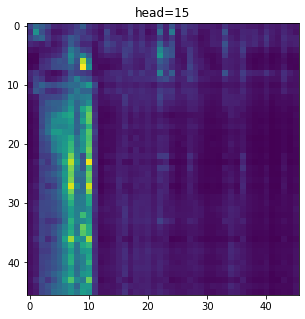

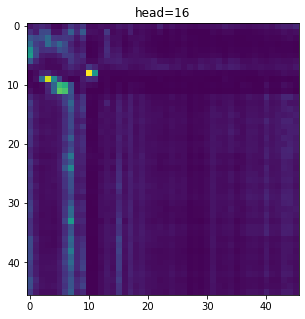

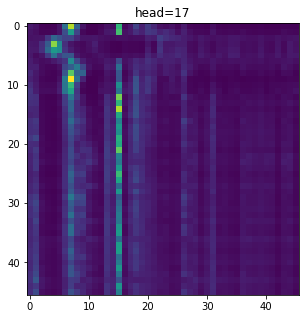

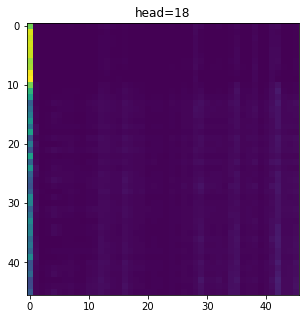

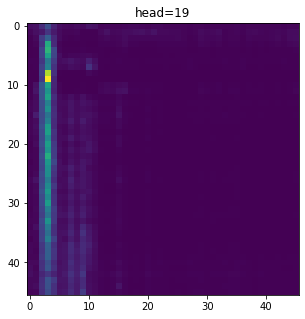

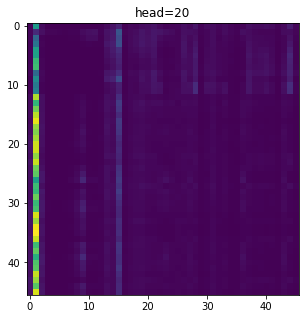

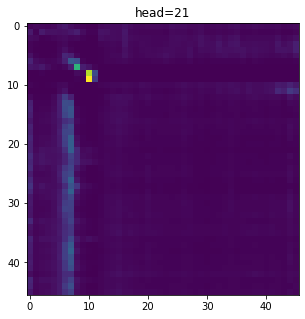

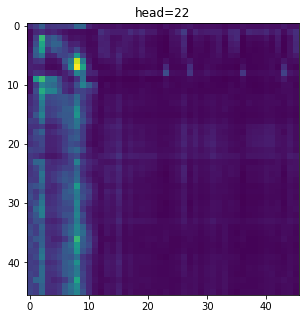

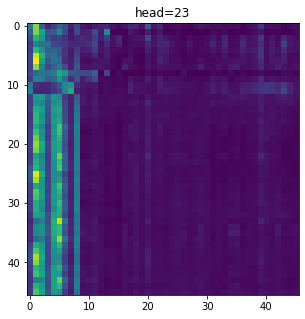

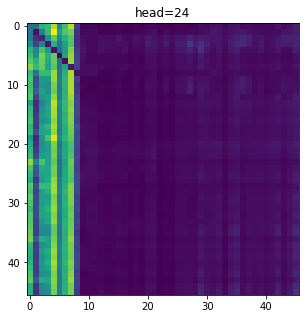

In [248]:
import numpy as np
for head in np.arange(0,25):
    attention = data_avg[head]
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.title('head={0}'.format(head))
    ax.imshow(attention)

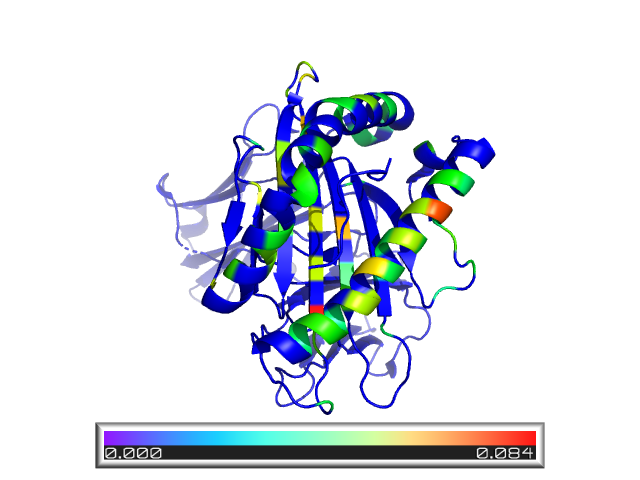

In [258]:
import bfactors
from pymol import cmd

head = 10

hla_head_vals = data_avg[head,0:60,0:60].mean(axis=0).numpy()
hla_head_mean = data_avg.mean(axis=0)[0:60,0:60].mean(axis=0).numpy()

# Fill in protein sites that are not processed by Transformer
hla_attn = bfactors.map_data_to_sites(hla_head_vals, '../data/variable_sites.txt')
hla_mean_attn = bfactors.map_data_to_sites(hla_head_mean, '../data/variable_sites.txt')

# Peptide level attention
pep_attn = data_avg[head,0:60,60:].mean(axis=1).numpy()
pep_mean_attn = data_avg.mean(axis=0)[0:60,60:].mean(axis=1).numpy()



# PyMol commands
cmd.load('../data/1jf1.pdb')
cmd.alter('1jf1',"b=0")

bfactors.reassign_b_factors('1jf1', 'A', hla_mean_attn)
#bfactors.reassign_b_factors('1jf1', 'C', pep_head_sum*100)

cmd.remove('resn hoh')
cmd.spectrum("b", "rainbow", "%s and n. CA " % '1jf1')
cmd.ramp_new("count", '1jf1', [min(hla_attn), max(hla_attn)], "rainbow")
cmd.recolor()
cmd.save('../output/1jf1_head.pdb')
cmd.ipython_image()

In [194]:

mol = '1jf1'
cmd.delete('1jf1')
cmd.load('../data/1jf1.pdb')

startaa=1
counter=int(startaa)
for val in hla_attn:	
    cmd.alter("%s and resi %s and n. CA"%(mol,counter), "b=%s"%val)
    counter=counter+1

cmd.spectrum("b","rainbow", "%s and n. CA " %mol)

(0.0, 61.630001068115234)

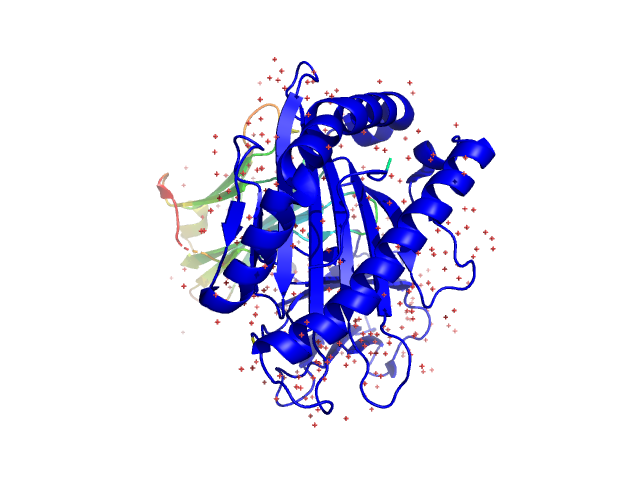

In [195]:
cmd.ipython_image()

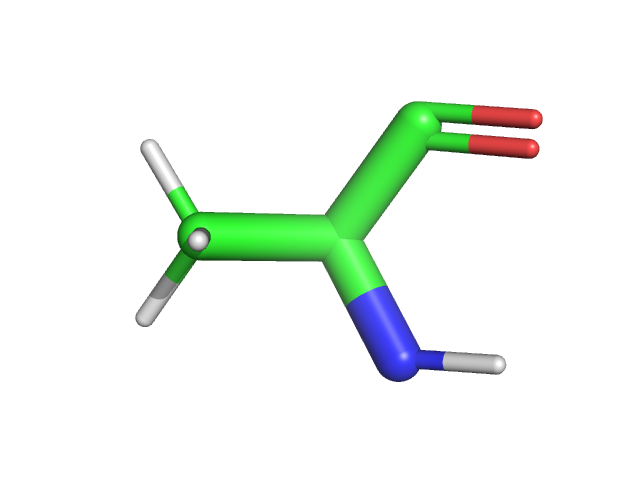

In [4]:
cmd.fragment('ala')
cmd.orient()

# since PyMOL 2.5
cmd.ipython_image()